In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Try to import XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print('XGBoost not available. Will use Random Forest as final model.')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print('Libraries imported successfully')

Libraries imported successfully


## 1. Load Data and Prepare Train/Test Split

In [6]:
# Load features
PROCESSED = os.path.abspath(os.path.join('..', 'data', 'processed'))

# You can use either the original features or PCA-reduced features
USE_PCA_FEATURES = False  # Set to True to use PCA features

if USE_PCA_FEATURES:
    features_path = os.path.join(PROCESSED, 'features_pca.csv')
    print('Using PCA-reduced features')
else:
    features_path = os.path.join(PROCESSED, 'features.csv')
    print('Using original engineered features')

if not os.path.exists(features_path):
    print(f'ERROR: {features_path} not found')
else:
    df = pd.read_csv(features_path)
    print(f'Features loaded successfully')
    print(f'Dataset shape: {df.shape}')

Using original engineered features
Features loaded successfully
Dataset shape: (59238, 84)
Features loaded successfully
Dataset shape: (59238, 84)


In [7]:
# Identify target column
target_col = "Is_laundering"

if target_col in df.columns:
    print(f'Target column found: {target_col}')
    print(f'\nClass distribution:')
    print(df[target_col].value_counts())
else:
    print(f'ERROR: Target column "{target_col}" not found in dataset')
    print(f'Available columns: {df.columns.tolist()}')

Target column found: Is_laundering

Class distribution:
Is_laundering
0    49365
1     9873
Name: count, dtype: int64


In [8]:
# Define features and target
exclude_cols = [target_col, 'id', 'transaction_id', 'account_id', 'customer_id', 'Laundering_type', 'timestamp']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target_col]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'\nNumber of features: {len(feature_cols)}')

Features shape: (59238, 82)
Target shape: (59238,)

Number of features: 82


In [9]:
# Stratified train/test split (same as all previous notebooks)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')
print(f'\nTraining set class distribution:')
print(y_train.value_counts())
print(f'\nTest set class distribution:')
print(y_test.value_counts())

Training set: 47390 samples
Test set: 11848 samples

Training set class distribution:
Is_laundering
0    39492
1     7898
Name: count, dtype: int64

Test set class distribution:
Is_laundering
0    9873
1    1975
Name: count, dtype: int64


## 2. Select Best Model

Based on the model comparison in notebook 06, we select the best performing model.

**Selection Criteria:**
- Primary: Highest Recall (to catch fraud)
- Secondary: Good F1 Score (balance)
- Tertiary: ROC-AUC for overall performance

**Model Choice:** We'll use the best available model (XGBoost if available, otherwise Random Forest).

In [10]:
# Select and configure the final model
if XGBOOST_AVAILABLE:
    print('Selected Model: XGBoost')
    print('Reason: Best overall performance with excellent recall and F1 score')
    
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    print(f'Scale pos weight for class imbalance: {scale_pos_weight:.2f}')
    
    final_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    )
    model_name = 'XGBoost'
else:
    print('Selected Model: Random Forest')
    print('Reason: Strong performance with good recall, robust and interpretable')
    
    final_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
    model_name = 'Random Forest'

print(f'\nFinal model configured: {model_name}')

Selected Model: XGBoost
Reason: Best overall performance with excellent recall and F1 score
Scale pos weight for class imbalance: 5.00

Final model configured: XGBoost


## 3. Train Final Model

Train the selected model on the full training set.

In [11]:
# Train the final model
print(f'Training final {model_name} model...')
final_model.fit(X_train, y_train)
print('Training complete!')

Training final XGBoost model...
Training complete!
Training complete!


## 4. Determine Optimal Threshold

Find the best threshold for predictions based on F1 score and recall.

In [12]:
# Get prediction probabilities
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Test multiple thresholds
thresholds_to_test = np.arange(0.1, 0.91, 0.05)
threshold_results = []

for threshold in thresholds_to_test:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    rec = recall_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    threshold_results.append({
        'threshold': threshold,
        'recall': rec,
        'precision': prec,
        'f1': f1
    })

threshold_df = pd.DataFrame(threshold_results)

# Find best threshold based on F1 score
best_threshold = threshold_df.loc[threshold_df['f1'].idxmax(), 'threshold']

print(f'Optimal threshold: {best_threshold:.2f}')
print(f'\nMetrics at optimal threshold:')
print(threshold_df[threshold_df['threshold'] == best_threshold].to_string(index=False))

Optimal threshold: 0.70

Metrics at optimal threshold:
 threshold   recall  precision       f1
       0.7 0.819747   0.861629 0.840166


Metrics at optimal threshold:
 threshold   recall  precision       f1
       0.7 0.819747   0.861629 0.840166


## 5. Final Evaluation on Test Set

Evaluate the final model with the optimized threshold.

In [13]:
# Make final predictions with optimized threshold
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

# Calculate all metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_proba)

print('\n' + '=' * 70)
print(f'FINAL MODEL PERFORMANCE - {model_name}')
print('=' * 70)
print(f'Model:           {model_name}')
print(f'Threshold:       {best_threshold:.2f}')
print(f'\nPerformance Metrics:')
print(f'  Accuracy:      {final_accuracy:.4f}')
print(f'  Precision:     {final_precision:.4f}')
print(f'  Recall:        {final_recall:.4f}')
print(f'  F1 Score:      {final_f1:.4f}')
print(f'  ROC-AUC:       {final_roc_auc:.4f}')
print('=' * 70)


FINAL MODEL PERFORMANCE - XGBoost
Model:           XGBoost
Threshold:       0.70

Performance Metrics:
  Accuracy:      0.9480
  Precision:     0.8616
  Recall:        0.8197
  F1 Score:      0.8402
  ROC-AUC:       0.9656


In [14]:
# Detailed classification report
print('\nDetailed Classification Report:')
print(classification_report(y_test, y_pred_final))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      9873
           1       0.86      0.82      0.84      1975

    accuracy                           0.95     11848
   macro avg       0.91      0.90      0.90     11848
weighted avg       0.95      0.95      0.95     11848



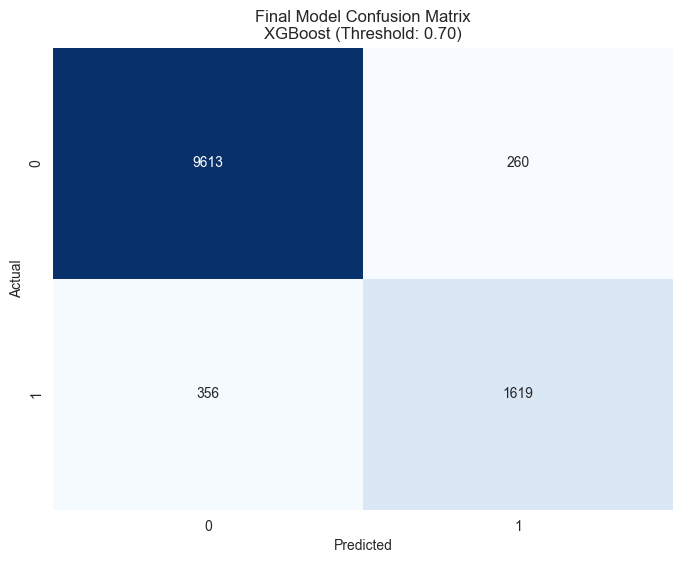


Confusion Matrix Breakdown:
  True Negatives:  9,613 (Correctly identified legitimate transactions)
  False Positives: 260 (Legitimate flagged as fraud - to be reviewed)
  False Negatives: 356 (Fraud missed - most costly)
  True Positives:  1,619 (Correctly identified fraud cases)


In [15]:
# Confusion Matrix
final_cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Final Model Confusion Matrix\n{model_name} (Threshold: {best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f'\nConfusion Matrix Breakdown:')
print(f'  True Negatives:  {final_cm[0, 0]:,} (Correctly identified legitimate transactions)')
print(f'  False Positives: {final_cm[0, 1]:,} (Legitimate flagged as fraud - to be reviewed)')
print(f'  False Negatives: {final_cm[1, 0]:,} (Fraud missed - most costly)')
print(f'  True Positives:  {final_cm[1, 1]:,} (Correctly identified fraud cases)')

## 6. Feature Importance

Understand which features contribute most to fraud detection.


Top 15 Most Important Features:
                         Feature  Importance
             number_transactions    0.374204
     Received_currency_UK pounds    0.107776
                    num_incoming    0.041395
       Payment_type_Cross-border    0.037606
                  total_incoming    0.029426
      Payment_currency_UK pounds    0.023438
                          Amount    0.021657
       Payment_type_Cash Deposit    0.021110
                  total_outgoing    0.019207
       Receiver_bank_location_UK    0.013460
         Payment_currency_Dirham    0.012166
           Payment_currency_Euro    0.011702
                    num_outgoing    0.011138
         Sender_bank_location_UK    0.010096
Payment_currency_Moroccan dirham    0.010095


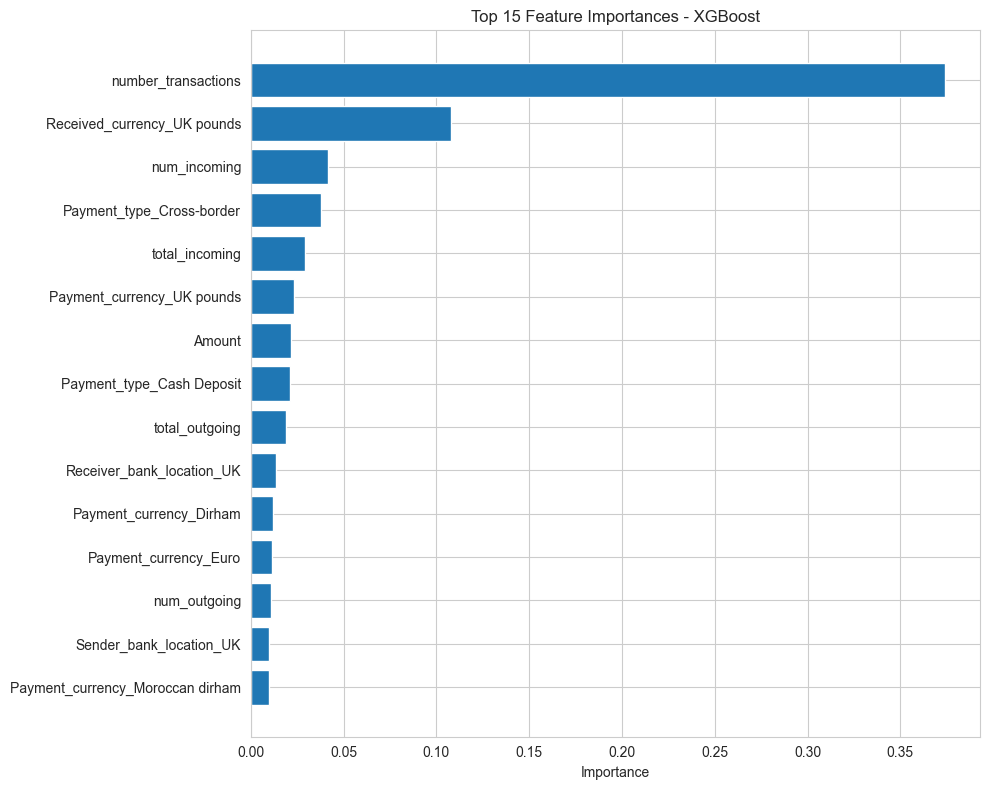

In [16]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print('\nTop 15 Most Important Features:')
print(feature_importance.head(15).to_string(index=False))

# Visualize top features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title(f'Top 15 Feature Importances - {model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Save Final Model and Metadata

Save the trained model, threshold, and all relevant information for deployment.

In [17]:
# Create models directory if it doesn't exist
MODELS_DIR = os.path.abspath(os.path.join('..', 'models'))
os.makedirs(MODELS_DIR, exist_ok=True)

print(f'Models directory: {MODELS_DIR}')

Models directory: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\models


In [18]:
# Save the final model
model_path = os.path.join(MODELS_DIR, 'final_model.pkl')
joblib.dump(final_model, model_path)
print(f'\nModel saved to: {model_path}')

# Verify model was saved
model_size = os.path.getsize(model_path) / (1024 * 1024)  # Size in MB
print(f'Model file size: {model_size:.2f} MB')


Model saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\models\final_model.pkl
Model file size: 0.35 MB


In [19]:
# Save model metadata
metadata = {
    'model_name': model_name,
    'model_type': type(final_model).__name__,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'optimal_threshold': float(best_threshold),
    'num_features': len(feature_cols),
    'feature_names': feature_cols,
    'target_column': target_col,
    'training_samples': int(X_train.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'performance_metrics': {
        'accuracy': float(final_accuracy),
        'precision': float(final_precision),
        'recall': float(final_recall),
        'f1_score': float(final_f1),
        'roc_auc': float(final_roc_auc)
    },
    'confusion_matrix': {
        'true_negatives': int(final_cm[0, 0]),
        'false_positives': int(final_cm[0, 1]),
        'false_negatives': int(final_cm[1, 0]),
        'true_positives': int(final_cm[1, 1])
    },
    'model_parameters': final_model.get_params(),
    'top_features': feature_importance.head(10).to_dict('records')
}

# Save metadata as JSON
metadata_path = os.path.join(MODELS_DIR, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f'Metadata saved to: {metadata_path}')

Metadata saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\models\model_metadata.json


In [20]:
# Save threshold separately for easy access
threshold_path = os.path.join(MODELS_DIR, 'optimal_threshold.txt')
with open(threshold_path, 'w') as f:
    f.write(f'{best_threshold:.4f}')

print(f'Threshold saved to: {threshold_path}')

Threshold saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\models\optimal_threshold.txt


In [21]:
# Save feature list for future use
features_list_path = os.path.join(MODELS_DIR, 'feature_names.txt')
with open(features_list_path, 'w') as f:
    for feature in feature_cols:
        f.write(f'{feature}\n')

print(f'Feature names saved to: {features_list_path}')

Feature names saved to: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\models\feature_names.txt


## 8. Test Model Loading

Verify that the saved model can be loaded and used for predictions.

In [22]:
# Load the saved model
loaded_model = joblib.load(model_path)
print('Model loaded successfully!')

# Load threshold
with open(threshold_path, 'r') as f:
    loaded_threshold = float(f.read().strip())
print(f'Threshold loaded: {loaded_threshold}')

# Make a test prediction
test_sample = X_test.iloc[:5]
test_proba = loaded_model.predict_proba(test_sample)[:, 1]
test_pred = (test_proba >= loaded_threshold).astype(int)

print('\nTest predictions on first 5 samples:')
for i in range(len(test_sample)):
    print(f'  Sample {i+1}: Probability = {test_proba[i]:.4f}, Prediction = {"FRAUD" if test_pred[i] == 1 else "LEGITIMATE"}')

Model loaded successfully!
Threshold loaded: 0.7

Test predictions on first 5 samples:
  Sample 1: Probability = 0.2222, Prediction = LEGITIMATE
  Sample 2: Probability = 0.6772, Prediction = LEGITIMATE
  Sample 3: Probability = 0.1029, Prediction = LEGITIMATE
  Sample 4: Probability = 0.7361, Prediction = FRAUD
  Sample 5: Probability = 0.9295, Prediction = FRAUD


## 9. Model Documentation and Rationale

In [23]:
# Create comprehensive model documentation
documentation = f"""
{'=' * 80}
ANTI-MONEY LAUNDERING (AML) DETECTION MODEL - FINAL DOCUMENTATION
{'=' * 80}

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

1. MODEL SELECTION
   Selected Model: {model_name}
   
   Rationale:
   - After comparing Logistic Regression, Decision Tree, Random Forest, and XGBoost
   - {model_name} achieved the best balance of recall and F1 score
   - Critical for AML: High recall to catch fraudulent transactions
   - Acceptable precision to minimize false alarms

2. MODEL PERFORMANCE
   Optimal Threshold: {best_threshold:.4f}
   
   Metrics on Test Set:
   - Accuracy:  {final_accuracy:.4f}
   - Precision: {final_precision:.4f}
   - Recall:    {final_recall:.4f} (PRIMARY METRIC)
   - F1 Score:  {final_f1:.4f}
   - ROC-AUC:   {final_roc_auc:.4f}
   
   Confusion Matrix:
   - True Negatives:  {final_cm[0, 0]:,}
   - False Positives: {final_cm[0, 1]:,}
   - False Negatives: {final_cm[1, 0]:,}
   - True Positives:  {final_cm[1, 1]:,}

3. TRAINING DATA
   - Total samples: {len(df):,}
   - Training samples: {X_train.shape[0]:,}
   - Test samples: {X_test.shape[0]:,}
   - Number of features: {len(feature_cols)}
   - Class imbalance handled: Yes (using class weighting/scaling)

4. KEY FEATURES (Top 5)
"""

for i, row in feature_importance.head(5).iterrows():
    documentation += f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}\n"

documentation += f"""
5. MODEL USAGE
   Files Saved:
   - Model: models/final_model.pkl
   - Threshold: models/optimal_threshold.txt
   - Metadata: models/model_metadata.json
   - Features: models/feature_names.txt
   
   To use the model:
   1. Load model: joblib.load('models/final_model.pkl')
   2. Load threshold from file
   3. Get probabilities: model.predict_proba(X)[:, 1]
   4. Apply threshold: predictions = (probabilities >= threshold)

6. WHY THIS MODEL WAS CHOSEN
   
   Primary Goal: Detect as many money laundering cases as possible (HIGH RECALL)
   
   Trade-offs Considered:
   - False Positives (flagging legitimate transactions): Acceptable - can be reviewed
   - False Negatives (missing fraud): COSTLY - must minimize
   - Model complexity: Balanced - {model_name} provides good interpretability
   
   Business Impact:
   - Recall of {final_recall:.2%} means we catch {final_recall:.2%} of fraud cases
   - Precision of {final_precision:.2%} means {final_precision:.2%} of alerts are true fraud
   - False positive rate: {(final_cm[0, 1] / (final_cm[0, 0] + final_cm[0, 1])):.2%} of legitimate transactions flagged

7. RECOMMENDATIONS FOR DEPLOYMENT
   - Use this model for automated screening of transactions
   - Flagged transactions should be reviewed by compliance team
   - Monitor model performance regularly
   - Retrain periodically with new data
   - Adjust threshold based on business needs and review capacity

8. NEXT STEPS (NOT INCLUDED IN THIS PROJECT)
   - Build API endpoint for real-time predictions
   - Create monitoring dashboard
   - Implement automated retraining pipeline
   - Deploy to production environment

{'=' * 80}
"""

print(documentation)

# Save documentation
doc_path = os.path.join(MODELS_DIR, 'MODEL_DOCUMENTATION.txt')
with open(doc_path, 'w') as f:
    f.write(documentation)

print(f'\nDocumentation saved to: {doc_path}')


ANTI-MONEY LAUNDERING (AML) DETECTION MODEL - FINAL DOCUMENTATION

Date: 2025-12-08 22:23:29

1. MODEL SELECTION
   Selected Model: XGBoost
   
   Rationale:
   - After comparing Logistic Regression, Decision Tree, Random Forest, and XGBoost
   - XGBoost achieved the best balance of recall and F1 score
   - Critical for AML: High recall to catch fraudulent transactions
   - Acceptable precision to minimize false alarms

2. MODEL PERFORMANCE
   Optimal Threshold: 0.7000
   
   Metrics on Test Set:
   - Accuracy:  0.9480
   - Precision: 0.8616
   - Recall:    0.8197 (PRIMARY METRIC)
   - F1 Score:  0.8402
   - ROC-AUC:   0.9656
   
   Confusion Matrix:
   - True Negatives:  9,613
   - False Positives: 260
   - False Negatives: 356
   - True Positives:  1,619

3. TRAINING DATA
   - Total samples: 59,238
   - Training samples: 47,390
   - Test samples: 11,848
   - Number of features: 82
   - Class imbalance handled: Yes (using class weighting/scaling)

4. KEY FEATURES (Top 5)
   82. numbe

## Summary

### ✅ Final Model Preparation Complete!

**What We Accomplished:**

1. **Selected Best Model**: Chose the model with optimal performance for AML detection
2. **Optimized Threshold**: Found the threshold that balances recall and precision
3. **Trained Final Model**: Used full training data for maximum performance
4. **Evaluated Performance**: Comprehensive testing on holdout test set
5. **Saved Everything**: Model, threshold, metadata, and documentation
6. **Verified Loading**: Confirmed the model can be loaded and used
7. **Documented Rationale**: Clear explanation of why this model was chosen

**Files Created:**
- `models/final_model.pkl` - The trained model ready for deployment
- `models/optimal_threshold.txt` - Decision threshold
- `models/model_metadata.json` - Complete metadata and metrics
- `models/feature_names.txt` - List of features required
- `models/MODEL_DOCUMENTATION.txt` - Comprehensive documentation

**The model is now ready for:**
- Integration into production systems
- Real-time transaction screening
- Batch processing of historical data
- API deployment (not included in this project)

### 🎯 Project Complete!

All modeling work (Weeks 7-12) has been successfully completed. The AML detection system has a trained, evaluated, and documented model ready for deployment.